In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import sys
import copy
import time
import logging
import argparse
import itertools
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from tqdm.auto import tqdm

import numpy as np
import ray

sys.path.insert(0, '../network')
from measures import DataStore

In [23]:
def slice_data(ds, output, keys, raise_on_error=False):
    for idxs, vals in zip(
        itertools.product(*[range(len(ds.keyvals[key])) for key in keys]),
        itertools.product(*[ds.keyvals[key] for key in keys])):
        try:
            output[idxs] = ds.data[vals]
        except:
            if raise_on_error:
                raise StandardError

#### Load retrieval speed phase diagram

In [24]:
@np.vectorize
def quality(val, combined=False, correlation=True):
    try:
        return val['q'][-1,:400].max()
    except:
        return np.NaN

@np.vectorize
def speed(val):
    try:
        q = val['q'][:,:400]
        idxs = q.argmax(axis=1)
        diffs = np.diff(idxs)
        diffs = diffs[np.logical_and(
            np.logical_and(
                diffs < diffs.mean()+2*diffs.std(),
                diffs > diffs.mean()-2*diffs.std()),
            diffs > 0)]
        return np.mean(diffs)
    except:
        return np.NaN

In [25]:
directory = "2-bilinear-phase-diagram/data/"
keys=['I_ext_1','I_ext_2']
n1, n2 = 33,33 
ds1 = DataStore(directory)
ds1.load()
ds1.process(keys)

  0%|          | 0/1089 [00:00<?, ?it/s]

In [26]:
output = np.zeros((n1,n2), dtype=object)
slice_data(ds1, output, keys)
q = quality(output)
s = speed(output)

#### Load input trajectory trials

In [43]:
I_ext_v1 = np.load("6-reward-driven/data/I_ext_v1.npy")
I_ext_v2 = np.load("6-reward-driven/data/I_ext_v2.npy")

In [77]:
matplotlib.rcParams['axes.linewidth'] = 2

/hpc/home/mhg19/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/hpc/home/mhg19/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


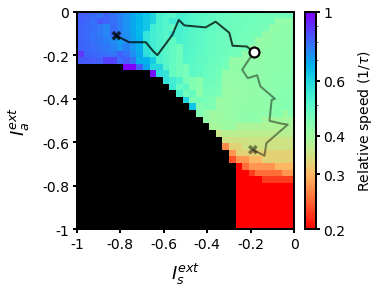

In [99]:
def plot(q, s, ds, I_ext_v1, I_ext_v2, tau=10):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    
    # Speed
    q[np.isnan(q)] = 0
    s[q < 0.05] = np.NaN
    cmap = copy.copy(matplotlib.cm.get_cmap("rainbow_r"))
    cmap.set_bad(color='black')
    s = tau/s
    im2 = ax.imshow(s, cmap=cmap, vmin=0.20, vmax=1, 
                       norm=colors.LogNorm(vmin=s.min(), vmax=s.max()))
    ax.set_xticks(np.linspace(0, n1, 6) - 0.5)
    ax.set_yticks(np.linspace(0, n2, 6) - 0.5)
    ax.set_xticklabels([-1, -0.8, -0.6, -0.4, -0.2, 0], fontsize=14)
    ax.set_yticklabels([-1, -0.8, -0.6, -0.4, -0.2, 0], fontsize=14)
    ax.set_xlim([-0.5, s.shape[0] - 0.5]);
    ax.set_ylim([-0.5, s.shape[1] - 0.5]);
    ax.set_xlabel(r"$I^{ext}_s$", fontsize=18, labelpad=10)
    ax.set_ylabel(r"$I^{ext}_a$", fontsize=18, labelpad=10)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.15)
    cb = fig.colorbar(im2, cax=cax, ticks=[0.2, 0.3, 0.4, 0.6, 1]);
    cb.set_label(r"Relative speed ($1/\tau$)", labelpad=10, fontsize=14)
    cb.ax.set_yticklabels([0.2, 0.3, 0.4, 0.6, 1])
    ax.tick_params(width=2, length=4)
    cb.ax.tick_params(width=2, length=4, labelsize=14)
    
    # Plot trials
    for I_ext, alpha in zip([I_ext_v1, I_ext_v2], [0.45, 0.75]):
        ax.scatter(
            n1 - I_ext[0][0] * -n1,
            n2 - I_ext[1][0] * -n2,
            s=95,
            color='white',
            marker='o',
            edgecolors='k',
            linewidth=2,
            alpha=1,
            zorder=3)
        
        ax.plot(
            n1 - I_ext[0] * -n1,
            n2 - I_ext[1] * -n2,
            color='k',
            linewidth=2,
            alpha=alpha)
        ax.scatter(
            n1 - I_ext[0][-1] * -n1,
            n2 - I_ext[1][-1] * -n2,
            s=95,
            color='k',
            marker='X',
            edgecolors='none',
            linewidth=2,
            alpha=alpha)
        
    plt.subplots_adjust(wspace=0.6)
    return fig, ax

fig, ax = plot(q, s, ds1, I_ext_v1, I_ext_v2)
fig.savefig("6.pdf", dpi=150, bbox_inches='tight')